# Population Segmentation With BERT Embeddings

In this notbook we will explore how to use Bert to extarct text features (Embeddings).
We will use pre-trained deep learning model to process the tweet text data. The text is a list of tweets from per author.
For a specific author, we will use the model to generate a vector representation (embeddings) for every tweet.
The author will be represented by the avreage embeddings of all the tweets

## Objective: Clustering Users by their Tweets

Our goal is to create a model that extracts users'features from their tweets and use the features to group the users into groups of similar individuals.

Under the hood, the model is actually made up of two models.

- DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
- The next model, a k-means clutering from scikit learn will take in the result of DistilBERT’s processing, and cluter the users.

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the tweets that we can use for clustering.




## Import the authors data (tweets, gender, age, and pernoality traits)

In [46]:
import pandas as pd
import numpy as np
from utilities.load_authors_data import load_authors_data
from utilities.load_tweets import load_tweets

path = "/Users/sromdhani/VeevaDataScientist/PopulationSegmentation/data/pan15/english/"
tweets, user_ids = load_tweets(path)

In [47]:
from utilities.clean_tweets import clean_tweets
for user, tweet in tweets.items():
    list_tweets = tweets[user]
    for idx, text in enumerate(list_tweets):
        list_tweets[idx] = clean_tweets(text)
    tweets[user] = list_tweets

## Data description

In [48]:
df_tweets = pd.DataFrame.from_dict(tweets, orient='index').transpose()

In [49]:
df_tweets.head()

,user711,user842,user103,user843,user314,user710,user937,user289,user458,user666,...,user709,user245,user279,user494,user641,user132,user873,user456,user495,user522
0,,,rahul raj films xd,fuzzies,never wants see gej ever cos hes devil alas in...,expensive 3 pms colors colored edges soft touc...,digitalhumanities authorshipattribution,,,,...,truth,job,,vi ampd weight loss supplements,want you premiered,,,,,
1,per second,,battles batch,,,4192 old so ive 15 left mine,via,,,,...,,,all omg ”,,free,,,,behind closed doors call it,gonna start uni
2,,initiation2011 zetalove,,,live forever smh,what comments sectioned off,,,,talent express feelings writing,...,games purely designing delegating,personally think jealousy issue self confidenc...,corner shshdhdhhdbs crying”,,weeks show,judges judge throw stuff bro talks,,,,creepy am
3,leavesteeth and road look better felt,right ate fucking bib hatewhites,college,,,of get resources compared characters,reduce utility usually increases it 12,,,dream think someone share you,...,,get jealous time girl loyal,weve dropped 4 vital,,huge via,,,nlp sentimentanalysisplease,out here,
4,ramadan mansour luis garavito mass murderers,like,university bangaloreon sunday nomoreexams,things designer sophisticated ineedhelp,,enemy try shoot gets close,images affects must common shared hardt 2010 p...,,,,...,instead even redblack,show care someone,lane somebody please call 911 ”,,u guys think it,whyd reply here,1855 1901,registered research nlp,,


In [50]:
df_tweets.shape

(100, 152)

## Clean Tweets

## Import DistilBERT Model


In [52]:
# import the huggingface transformers library so we can load our deep learning NLP model.

import torch
import transformers as ppb

# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (
ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

## Extract Embeddings Features

Before we can hand our sentences to BERT, we need to do some minimal processing to put tweets in the format it requires : Tokenization, Padding and Masking

In [53]:
users_features_vector = {}

#every user in a column
for user_id in df_tweets:

    ## Step1: Tokenization
    tokenized = df_tweets[user_id].dropna().apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    ## Setp2: Padding
    max_len = 0

    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

    ## Step3: Masking

    attention_mask = np.where(padded != 0, 1, 0)

    ##################
    # Use DistilBert to embed all the tweets
    ##################

    input_ids = torch.tensor(padded)
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)

    features = last_hidden_states[0][:, 0, :].numpy()
    user_tweets_vector = features.mean(axis=0)
    users_features_vector[user_id] = user_tweets_vector


Save the embedding features

In [54]:
users_features = pd.DataFrame.from_dict(users_features_vector, orient='index')
users_features.to_csv('/Users/sromdhani/VeevaDataScientist/projects/populationsegmentation/data/users_embeddings.csv', index=True, header=False, encoding='utf-8')

In [55]:
users_features.shape

(152, 768)

In [56]:
users_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,...,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,-0.188352,-0.068105,0.026151,-0.151557,-0.027290,-0.063511,0.128000,0.264518,-0.212404,-0.207607,...,0.095842,-0.049125,0.068968,-0.081742,0.147309,-0.101132,-0.055506,-0.098749,0.158360,0.252727
std,0.019709,0.015317,0.023499,0.020182,0.022856,0.016107,0.033649,0.022059,0.022637,0.019087,...,0.021824,0.037926,0.013144,0.014576,0.018280,0.019472,0.014214,0.020385,0.020159,0.026757
min,-0.263608,-0.122912,-0.061573,-0.208800,-0.101918,-0.122092,0.068151,0.221641,-0.252886,-0.303876,...,0.063226,-0.157161,0.042627,-0.148104,0.115254,-0.160551,-0.091742,-0.172552,0.108572,0.205008
25%,-0.197054,-0.077342,0.018054,-0.163378,-0.039615,-0.071696,0.105991,0.248545,-0.226182,-0.214708,...,0.081651,-0.066320,0.061570,-0.088327,0.134523,-0.112737,-0.063336,-0.108375,0.145272,0.232479
50%,-0.187811,-0.066759,0.032170,-0.155429,-0.026504,-0.062201,0.123704,0.263378,-0.218390,-0.204595,...,0.090460,-0.045134,0.068680,-0.079373,0.143796,-0.101404,-0.055836,-0.093416,0.154650,0.247058
75%,-0.176838,-0.059422,0.041043,-0.142533,-0.010956,-0.052756,0.146039,0.275786,-0.201084,-0.195676,...,0.103138,-0.019611,0.074376,-0.072800,0.155873,-0.091945,-0.050342,-0.084625,0.168883,0.265322
max,-0.150814,-0.015678,0.077411,-0.048180,0.016606,-0.015253,0.257387,0.334712,-0.148784,-0.163371,...,0.197486,0.021437,0.125621,-0.046108,0.208673,-0.023989,0.006694,-0.048442,0.230800,0.363555


In [57]:
users_features.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
user711,-0.198318,-0.106419,0.018984,-0.090797,-0.059680,-0.096222,0.134384,0.287929,-0.148784,-0.215554,...,0.090799,-0.125994,0.047595,-0.075697,0.163464,-0.023989,-0.067622,-0.138690,0.185733,0.278763
user842,-0.197305,-0.065122,0.037981,-0.155519,-0.033415,-0.080459,0.160763,0.283618,-0.205282,-0.186378,...,0.072937,-0.076966,0.052827,-0.085211,0.168930,-0.100490,-0.064043,-0.097118,0.185693,0.254046
user103,-0.165300,-0.100891,0.008179,-0.137342,-0.039990,-0.092055,0.187289,0.295522,-0.178817,-0.203718,...,0.121103,-0.071716,0.087902,-0.090871,0.155789,-0.072571,-0.051577,-0.118038,0.170409,0.279681
user843,-0.190437,-0.055425,0.020180,-0.158050,-0.051144,-0.078805,0.181974,0.301229,-0.190891,-0.237362,...,0.074630,-0.099642,0.064494,-0.079619,0.172424,-0.090437,-0.066311,-0.106258,0.192028,0.259175
user314,-0.168332,-0.023989,0.028810,-0.156897,-0.034895,-0.068242,0.132686,0.271015,-0.197808,-0.203936,...,0.063226,-0.089028,0.050126,-0.046108,0.156123,-0.093153,-0.076163,-0.102791,0.128313,0.220588


## Find the Optimal numbers of clusters

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

In [58]:
from sklearn.cluster import KMeans, MiniBatchKMeans
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(users_features)
    Sum_of_squared_distances.append(km.inertia_)

As k increases, the sum of squared distance tends to zero. Imagine we set k to its maximum value n (where n is number of samples) each sample will form its own cluster meaning sum of squared distances equals zero.
Below is a plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k.

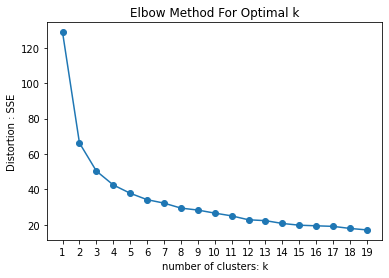

In [59]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, marker='o')
plt.xticks(K)
plt.xlabel('number of clusters: k')
plt.ylabel('Distortion : SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

The output plot depicts a sharp decrease for the number of clusters from values 1 to 3 with a slight decrease from 3 to 4 which estimates a 3-cluster solution.

## Perform K-means clustering with clusters k=3

In [60]:
km = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=1, verbose=True)

In [61]:
y_km = km.fit_predict(users_features)

Initialization complete
Iteration 0, inertia 86.99765645801537
Iteration 1, inertia 62.52167452992676
Iteration 2, inertia 62.38387562407658
Converged at iteration 2: center shift 0.0 within tolerance 1.1028058678641926e-07


In [70]:
y_km

array([2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0],
      dtype=int32)

## Perform Dimentionality Reduction with PCA to visualize the clusters

PCA is a dimensionality reduction algorithm which visualizes the essence of the dataset through data decomposition and transformation into principal components (PC) maximizing the linear variance of the data (More variance indicates more understanding of the data)⁵. As compared to K-means, PCA is not a direct solution and thus from a different perspective can help to detect customer clusters not found by K-means. PCA is used here for this research question as a valuable cross-check to K-means number of clusters determination.

### Find the optimal numbers of components

In this step, we will find the optimal number of components which capture the greatest amount of variance in the data. 

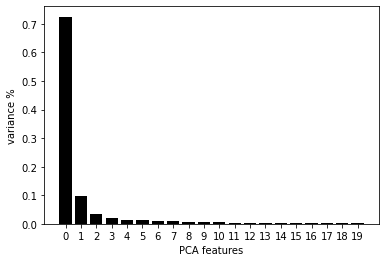

In [62]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(users_features)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

We found that the first two/three components explain the majority of the variance in our data. 

Let's quickly plot just the first two components. We do this to notice if there are any clear clusters.

Text(0, 0.5, 'PCA 2')

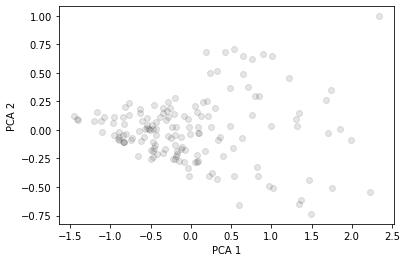

In [63]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

## Apply PCA Dimentionality Reduction to visualize the clusters

In [82]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(users_features)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [83]:
principalDf.head()

,PC1,PC2
0,1.854139,0.007130
1,0.529627,-0.155982
2,1.002374,0.036302
3,0.823367,-0.327946
4,0.230449,-0.402214


In [84]:
principalDf.shape

(152, 2)

In [85]:
principalDf['users'] = users_features.index.values
principalDf['cluster'] = y_km

In [86]:
principalDf.head()

,PC1,PC2,users,cluster
0,1.854139,0.007130,user711,2
1,0.529627,-0.155982,user842,2
2,1.002374,0.036302,user103,2
3,0.823367,-0.327946,user843,2
4,0.230449,-0.402214,user314,0


In [104]:
principalDf.describe()

,PC1,PC2,cluster
count,1.520000e+02,1.520000e+02,152.000000
mean,2.454177e-16,-4.236377e-17,0.532895
std,7.861407e-01,2.864841e-01,0.883384
min,-1.450181e+00,-7.356113e-01,0.000000
25%,-5.237902e-01,-1.706309e-01,0.000000
50%,-1.682545e-01,1.764580e-03,0.000000
75%,4.106500e-01,1.289760e-01,2.000000
max,2.332885e+00,9.960492e-01,2.000000


In [87]:
path = "data/pan15/english/"
authors_data = load_authors_data(path)

In [88]:
authors_data.head()

,gender,age_group,extraverted,stable,agreeable,conscientious,open,tweets
user552,M,25-34,0.3,0.5,0.1,0.2,0.2,[How to Test Your Startup Idea for $50 http://...
user865,M,25-34,0.2,0.4,0.2,0.0,0.2,[Everyday I come up with a new optimum solutio...
user103,M,18-24,0.1,0.2,0.1,0.1,0.1,[@username @username @username @username #IfM...
user179,F,18-24,0.1,0.1,-0.1,0.5,0.1,"[I wish we could talk forever.\t\t, 100000 thi..."
user321,F,18-24,0.0,-0.1,0.1,0.3,0.4,"[icarly ^^\t\t, thuis<3\t\t, Homework finished..."


In [89]:
users_clusters= pd.merge(principalDf, authors_data, how='inner', on=None, left_on='users', right_on=None,
         left_index=False, right_index=True)
users_clusters.head()

,PC1,PC2,users,cluster,gender,age_group,extraverted,stable,agreeable,conscientious,open,tweets
0,1.854139,0.007130,user711,2,M,25-34,0.2,0.2,0.1,0.1,0.5,[@username does Heroes of the Storm count?\t\t...
1,0.529627,-0.155982,user842,2,F,25-34,0.2,-0.3,0.2,0.3,0.2,[@username is straightening my hair #sisters\t...
2,1.002374,0.036302,user103,2,M,18-24,0.1,0.2,0.1,0.1,0.1,[@username @username @username @username #IfM...
3,0.823367,-0.327946,user843,2,F,25-34,0.2,-0.3,0.2,0.3,0.2,[Hanging Christmas lights at our apartment giv...
4,0.230449,-0.402214,user314,0,F,25-34,0.2,0.0,0.0,0.3,0.4,"[After writing volumes of ""My watch"" one would..."


## Plot Users Clusters by age

In [92]:
r= users_clusters[((users_clusters['cluster'] == 0) & (users_clusters['gender']=='M'))]['PC1']
r.shape

(56,)

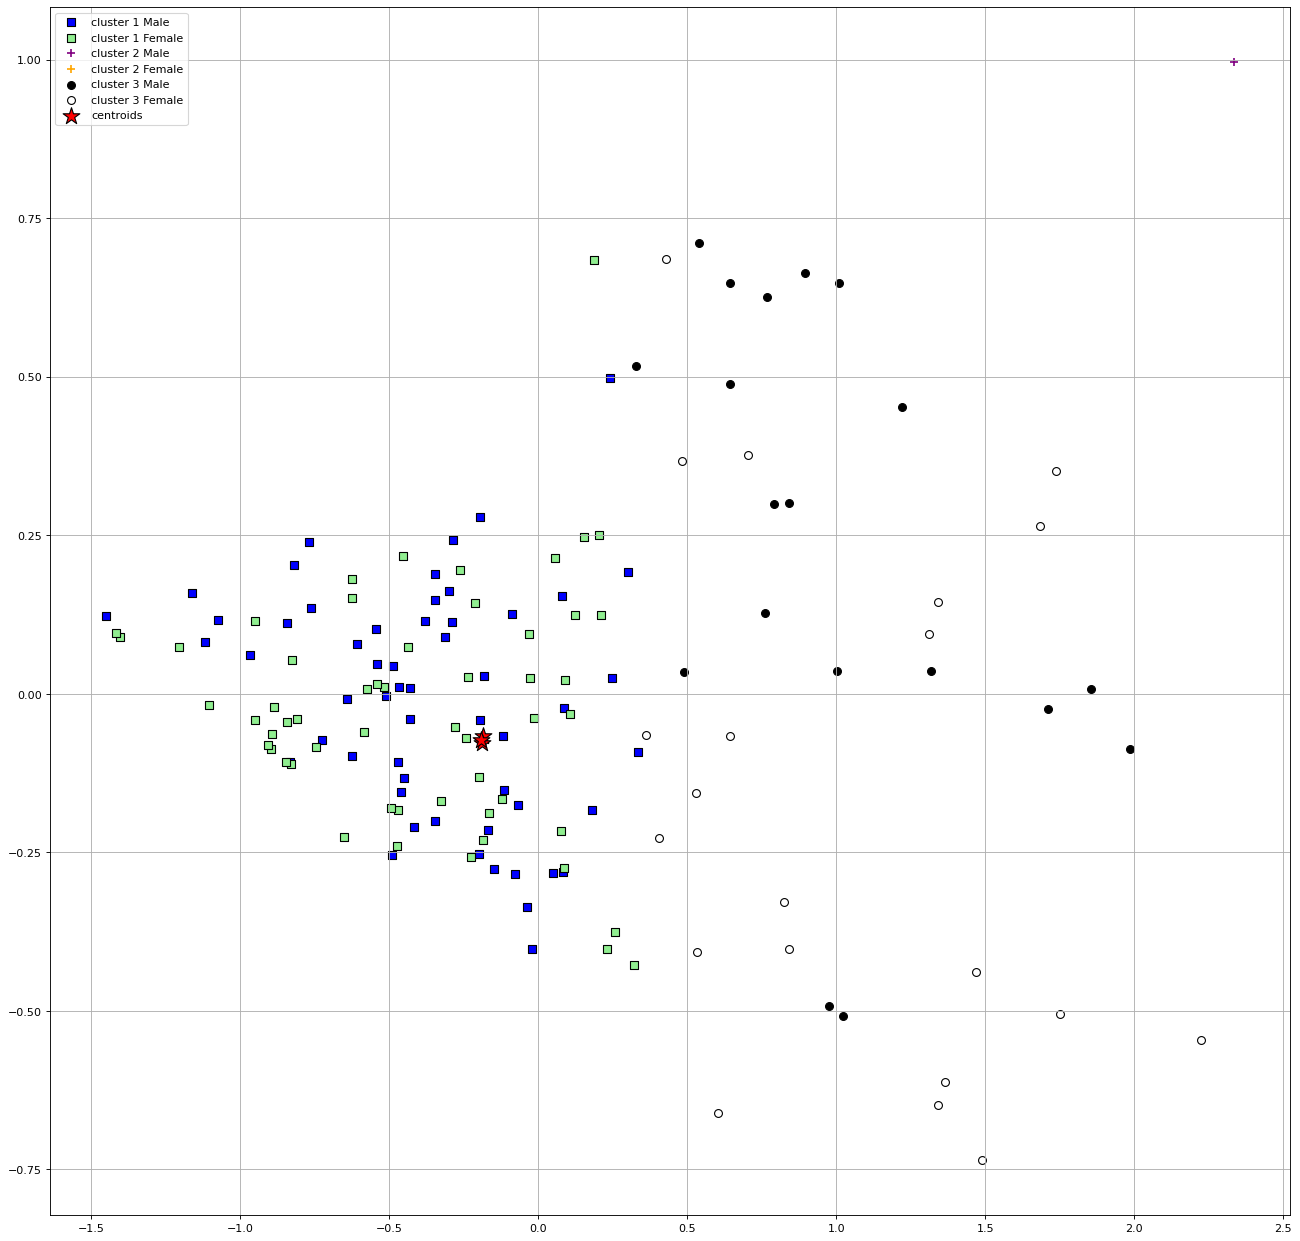

In [108]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go

# plot the 2 clusters
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(
    users_clusters[((users_clusters['cluster'] == 0) & (users_clusters['gender']=='M'))]['PC1'], users_clusters[((users_clusters['cluster'] == 0) & (users_clusters['gender']=='M'))]['PC2'],
    s=50, c='blue',
    marker='s', edgecolor='black',
    label='cluster 1 Male'
)

plt.scatter(
    users_clusters[((users_clusters['cluster'] == 0) & (users_clusters['gender']=='F'))]['PC1'], users_clusters[((users_clusters['cluster'] == 0) & (users_clusters['gender']=='F'))]['PC2'],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1 Female'
)

plt.scatter(
    users_clusters[((users_clusters['cluster'] == 1) & (users_clusters['gender']=='M'))]['PC1'], users_clusters[((users_clusters['cluster'] == 1) & (users_clusters['gender']=='M'))]['PC2'],
    s=50, c='purple',
    marker='+', edgecolor='black',
    label='cluster 2 Male'
)

plt.scatter(
    users_clusters[((users_clusters['cluster'] == 1) & (users_clusters['gender']=='F'))]['PC1'], users_clusters[((users_clusters['cluster'] == 1) & (users_clusters['gender']=='F'))]['PC2'],
    s=50, c='orange',
    marker='+', edgecolor='black',
    label='cluster 2 Female'
)

plt.scatter(
    users_clusters[((users_clusters['cluster'] == 2) & (users_clusters['gender']=='M'))]['PC1'], users_clusters[((users_clusters['cluster'] == 2) & (users_clusters['gender']=='M'))]['PC2'],
    s=50, c='black',
    marker='o', edgecolor='black',
    label='cluster 3 Male'
)

plt.scatter(
    users_clusters[((users_clusters['cluster'] == 2) & (users_clusters['gender']=='F'))]['PC1'], users_clusters[((users_clusters['cluster'] == 2) & (users_clusters['gender']=='F'))]['PC2'],
    s=50, c='white',
    marker='o', edgecolor='black',
    label='cluster 3 Female'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

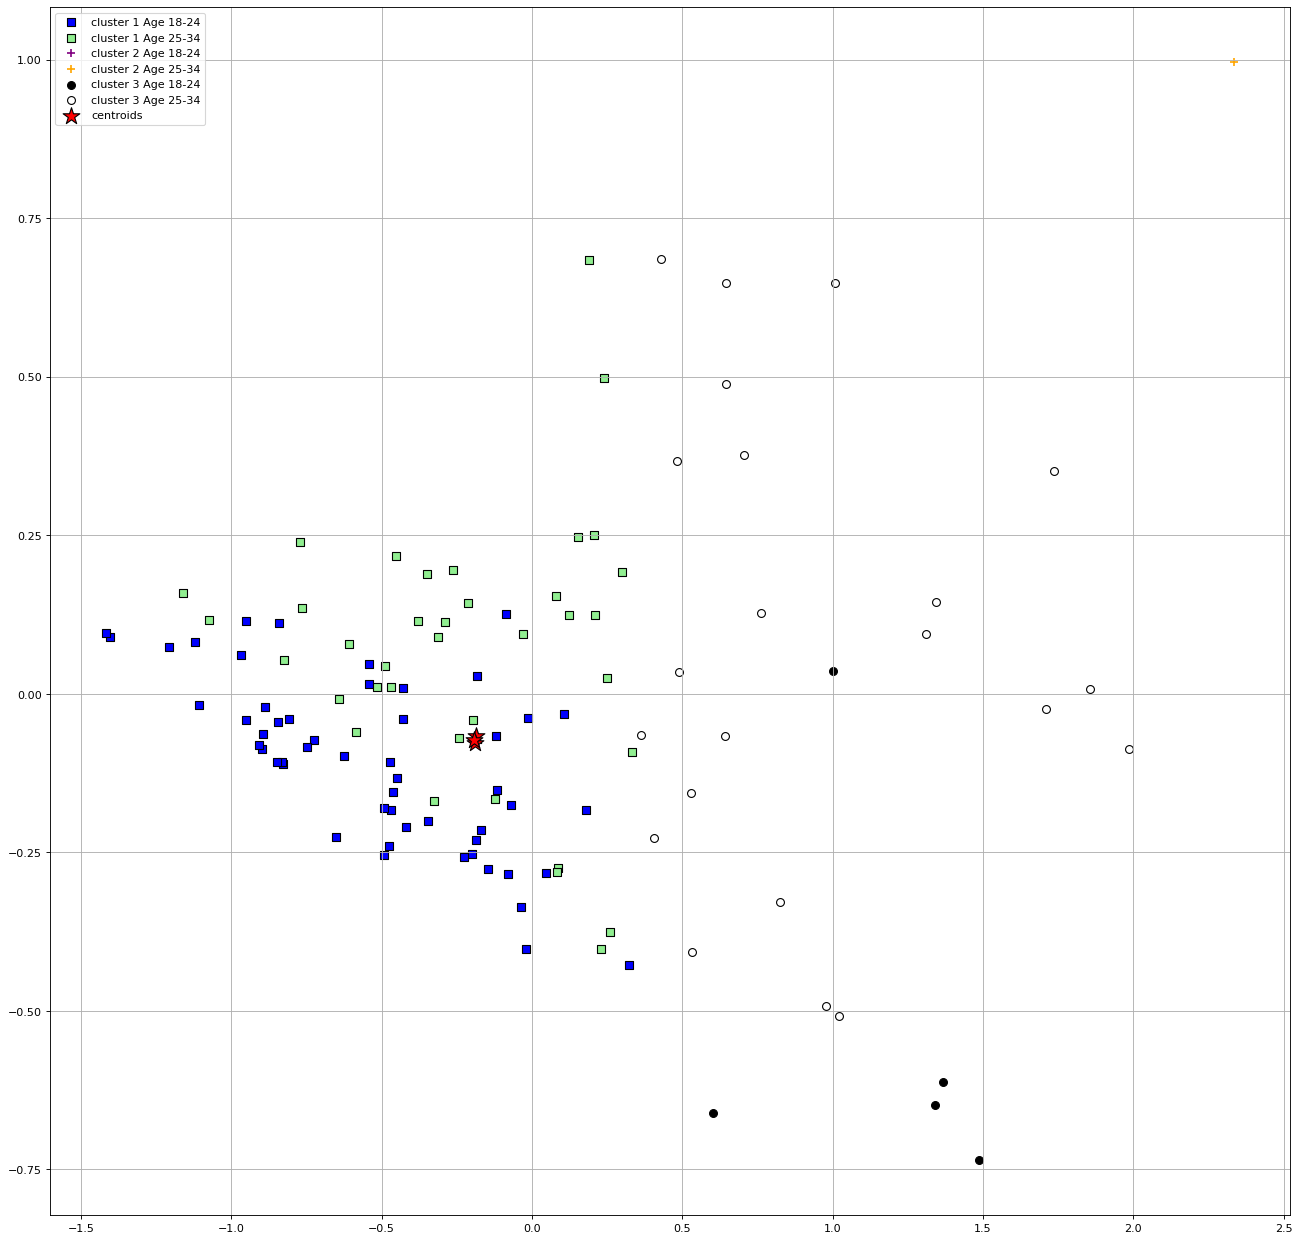

In [103]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go


# plot the 2 clusters
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(
    users_clusters[((users_clusters['cluster'] == 0) & (users_clusters['age_group']=='18-24'))]['PC1'], users_clusters[((users_clusters['cluster'] == 0) & (users_clusters['age_group']=='18-24'))]['PC2'],
    s=50, c='blue',
    marker='s', edgecolor='black',
    label='cluster 1 Age 18-24'
)

plt.scatter(
    users_clusters[((users_clusters['cluster'] == 0) & (users_clusters['age_group']=='25-34'))]['PC1'], users_clusters[((users_clusters['cluster'] == 0) & (users_clusters['age_group']=='25-34'))]['PC2'],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1 Age 25-34'
)

plt.scatter(
    users_clusters[((users_clusters['cluster'] == 1) & (users_clusters['age_group']=='18-24'))]['PC1'], users_clusters[((users_clusters['cluster'] == 1) & (users_clusters['age_group']=='18-24'))]['PC2'],
    s=50, c='purple',
    marker='+', edgecolor='black',
    label='cluster 2 Age 18-24'
)

plt.scatter(
    users_clusters[((users_clusters['cluster'] == 1) & (users_clusters['age_group']=='25-34'))]['PC1'], users_clusters[((users_clusters['cluster'] == 1) & (users_clusters['age_group']=='25-34'))]['PC2'],
    s=50, c='orange',
    marker='+', edgecolor='black',
    label='cluster 2 Age 25-34'
)

plt.scatter(
    users_clusters[((users_clusters['cluster'] == 2) & (users_clusters['age_group']=='18-24'))]['PC1'], users_clusters[((users_clusters['cluster'] == 2) & (users_clusters['age_group']=='18-24'))]['PC2'],
    s=50, c='black',
    marker='o', edgecolor='black',
    label='cluster 3 Age 18-24'
)

plt.scatter(
    users_clusters[((users_clusters['cluster'] == 2) & (users_clusters['age_group']=='25-34'))]['PC1'], users_clusters[((users_clusters['cluster'] == 2) & (users_clusters['age_group']=='25-34'))]['PC2'],
    s=50, c='white',
    marker='o', edgecolor='black',
    label='cluster 3 Age 25-34'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids',
    
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()